In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import random_tour
import osmnx as ox

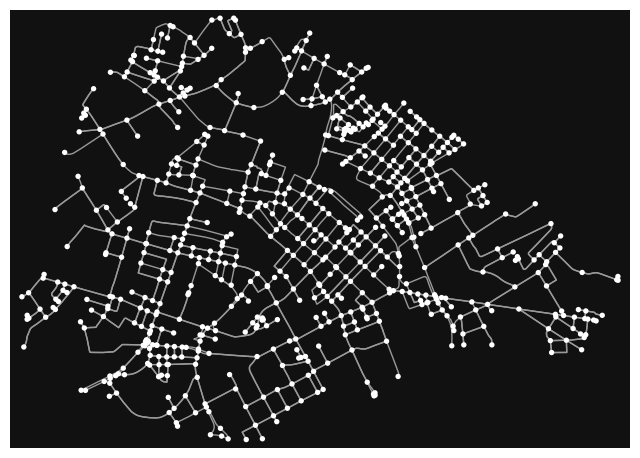

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [22]:
G = ox.graph_from_place('City Centre, Manchester, UK', network_type='drive', retain_all=False)
ox.plot_graph(G)

In [23]:
def cost_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        path = nx.shortest_path(G, u,v, weight='length')
        weight = nx.path_weight(G,path, weight="length")
        cost += weight
        last_node = tour[len(tour) - 1]
        first_node = tour[0]
        path1 = nx.shortest_path(G, first_node,last_node, weight='length')
        weight1 = nx.path_weight(G,path1, weight="length")
        cost += weight1
       
    return cost

In [25]:
def ordOne_crossover(firstPermutation, secondPermutation):
    length = len(firstPermutation)
    
    # choose the start and the end of the segment 
    # to be copied from the first parent
    start_Segment = random.randint(0, length // 2)
    end_Segment = random.randint(length // 2 + 1, length - 1) + 1
    
    # create a child
    child = list()
    
    # add the randomaly selected segment from the first parent
    child.extend(firstPermutation[start_Segment: end_Segment])
    
    # add what is left from the second parent that wasn't added from the first parent
    residueFromSegment = list(set(secondPermutation) - set(firstPermutation[start_Segment: end_Segment]))
    child.extend(residueFromSegment)
    
    return child

In [26]:
def swap_mutation(permutation):
    # copying the list so we don't mess with the original
    child = permutation[:]

    length = range(len(child))

    # choose two random gene position so they could be swaped
    first_gene_pos, second_gene_pos = random.sample(length, 2)

    # swapping 
    child[first_gene_pos], child[second_gene_pos] =\
    child[second_gene_pos], child[first_gene_pos] 

    return child

In [27]:
picadilly = ox.distance.nearest_nodes(G,-2.2312,53.4774)
oxford = ox.distance.nearest_nodes(G,-2.2422,53.4741)
library = ox.distance.nearest_nodes(G,-2.244666,53.478062)
MOSI = ox.distance.nearest_nodes(G,-2.25333232,53.472831442)

all_nodes = [picadilly,oxford,library,MOSI]
print(all_nodes)

[347454437, 30891675, 4833840, 5774104183]


In [28]:
# remember that ERO takes the graph as input
# not like PMX or Order 1
crossover = ordOne_crossover
mutate = swap_mutation

size_of_population = 5
ngen = 2000
best_at_gen = [] # for keeping track of the best tour at a given generation


pool = [*random_tour(all_nodes, number_of_perms=size_of_population)]
print(pool)

[[30891675, 5774104183, 347454437, 4833840], [347454437, 5774104183, 30891675, 4833840], [30891675, 4833840, 347454437, 5774104183], [347454437, 30891675, 5774104183, 4833840], [4833840, 5774104183, 30891675, 347454437]]


In [29]:
for generation in tqdm(range(ngen)):
    # 1- crossover every consecutive pair of routes
    # 2- replace the weakest of the two parent with the product of the crossover
    # 3- mutate the whole pool
    # 4- repeat and save the value best tour in that generation
    
    # 1-
    for parent1, parent2 in zip(pool, pool[1:]):
        child = crossover(parent1, parent2)
        
        # 2-
        if cost_tour(G, parent1) > cost_tour(G, parent2):
            pool[pool.index(parent2)] = child
        else:
            pool[pool.index(parent1)] = child
    
    # 3-
    for i in range(size_of_population):
        pool[i] = mutate(pool[i])
    
    # 4-
    best_at_gen.append(cost_tour(G, min(pool, key = lambda tour : cost_tour(G, tour))))

tour = min(pool, key = lambda route : cost_tour(G, route)) # result
tour_cost = cost_tour(G, tour) #result cost
print(all_nodes)
print(cost_tour(G,all_nodes))
print (tour)
print(tour_cost)

  0%|          | 0/2000 [00:00<?, ?it/s]

[347454437, 30891675, 4833840, 5774104183]
7847.370000000001
[4833840, 347454437, 30891675, 5774104183]
6299.789000000001


[4833840, 347454437, 30891675, 5774104183]


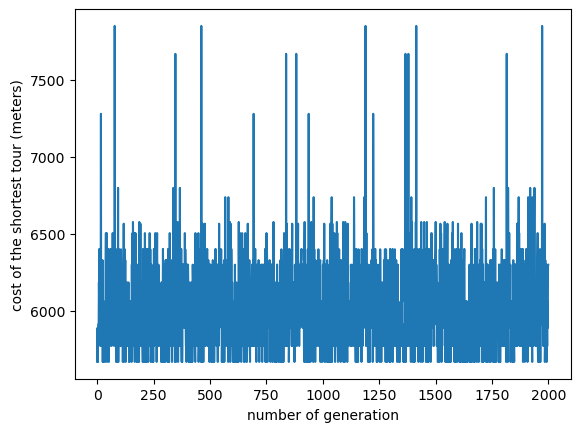

In [30]:
tour = min(pool, key = lambda route : cost_tour(G, route)) # result
tour_cost = cost_tour(G, tour) #result cost
print (tour)
plt.xlabel("number of generation")
plt.ylabel("cost of the shortest tour (meters)")
plt.plot(best_at_gen)
plt.show()

In [ ]:
def full_path(G, tour):
    path_1 = []
   
    for u,v in zip(tour, tour[1:]):
         path = nx.shortest_path(G, u,v, weight='length')
         path_1.append(path)

    path2 = nx.shortest_path(G, tour[-1],tour[0], weight='length')
    path_1.append(path2)
    return path_1

In [ ]:

def get_center(G):
    undir = G.to_undirected()
    length_func = nx.single_source_dijkstra_path_length
    sp = {source: dict(length_func(undir, source, weight="length")) for source in G.nodes}
    eccentricity = nx.eccentricity(undir,sp=sp)
    center_osmid = nx.center(undir,e=eccentricity)[0]
    return center_osmid

In [ ]:
fullPath = full_path(G,tour)
import ipyleaflet as lf
import folium as fl
zoom = 15
force_leaflet=False

route = fullPath[0]

center_osmid = get_center(G)
G_gdfs = ox.graph_to_gdfs(G)
nodes_frame = G_gdfs[0]
ways_frame = G_gdfs[1]

center_node = nodes_frame.loc[center_osmid]
location = (center_node['y'], center_node['x'])

m = lf.Map(center = location, zoom = zoom)


for item in fullPath:
    route = item
    start_node = nodes_frame.loc[route[0]]
    end_node = nodes_frame.loc[route[len(route)-1]]

    start_xy = (start_node['y'], start_node['x'])
    end_xy = (end_node['y'], end_node['x'])


    if len(route) >= 500 and not force_leaflet:
        print(f"The route has {len(G)} elements, using folium to improve performance.")
        m = ox.plot_route_folium(G = G, route = route, zoom= zoom, color='red')
        fl.Marker(location=start_xy).add_to(m)
        fl.Marker(location=end_xy).add_to(m)
      
    marker = lf.Marker(location = start_xy, draggable = False)
    m.add_layer(marker)
    marker = lf.Marker(location = end_xy, draggable = False)
    m.add_layer(marker)

    for u, v in zip(route[0:], route[1:]):
        
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        ant_path = lf.AntPath(
            locations = [*points], 
            dash_array=[1, 10],
            delay=1000,
            color='red',
            pulse_color='black'
        )
        m.add_layer(ant_path)

 
m